In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from Sequence import Sequence
from matplotlib.patches import Rectangle
from skimage import io
from utils import get_subwindow, get_scale_subwindow
import os
from pyhog import pyhog

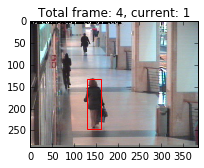

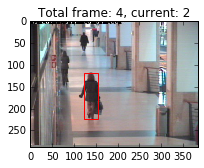

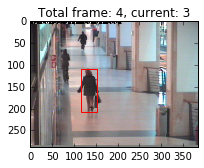

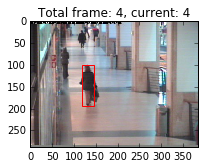

In [2]:
# Visualize Sequence 

sequence = Sequence(path = os.getcwd(), name='tutorials/img_ScaleChange', 
                    region_format='rectangle')
plt.clf()

while sequence._frame < len(sequence._images):
    
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    plt.figure(figsize=(3,3))
    tracking_figure_axes = plt.subplot(111)
    tracking_figure_axes.add_patch(gt_rect)
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence

In [3]:
padding = 1.0
output_sigma_factor = 1/float(16)
scale_sigma_factor = 1/float(4)
lamda = 1e-2
lamda_scale = 1e-2
interp_factor = 0.025

nScales = 33 # number of scale levels
scale_model_factor = 1.0 
scale_step = 1.02 # step of one scale level
scale_model_max_area = 32*16

scaleFactors used for scale estimation:
[ 1.37278571  1.34586834  1.31947876  1.29360663  1.26824179  1.24337431
  1.21899442  1.19509257  1.17165938  1.14868567  1.12616242  1.1040808
  1.08243216  1.061208    1.0404      1.02        1.          0.98039216
  0.96116878  0.94232233  0.92384543  0.90573081  0.88797138  0.87056018
  0.85349037  0.83675527  0.8203483   0.80426304  0.78849318  0.77303253
  0.75787502  0.74301473  0.72844581]
Gaussian shaped vector for scale estimation:
[  1.11537587e-27   2.04743479e-24   2.31436520e-21   1.61096714e-18
   6.90517119e-16   1.82261608e-13   2.96243564e-11   2.96507462e-09
   1.82749127e-07   6.93598224e-06   1.62103956e-04   2.33298653e-03
   2.06758717e-02   1.12836187e-01   3.79197929e-01   7.84723194e-01
   1.00000000e+00   7.84723194e-01   3.79197929e-01   1.12836187e-01
   2.06758717e-02   2.33298653e-03   1.62103956e-04   6.93598224e-06
   1.82749127e-07   2.96507462e-09   2.96243564e-11   1.82261608e-13
   6.90517119e-16   1.61096714

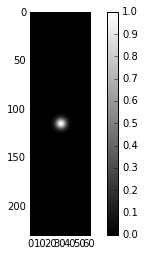

In [4]:
# get image, region and target Gaussian shape for training

img_raw = io.imread(sequence.frame()) 

data = sequence.groundtruth[sequence._frame]
X = data.x
Y = data.y
width = data.width
height = data.height
target_size = [height, width]
target_size = np.array(target_size)
pos = [Y+height/2.,X+width/2.]

init_target_size = target_size
currentScaleFactor = 1.0
base_target_size = target_size / currentScaleFactor
sz = np.floor(base_target_size * (1 + padding))

# Gaussian shaped label for location
output_sigma = np.sqrt(np.prod(target_size)) * output_sigma_factor
scale_sigma = np.sqrt(nScales) * scale_sigma_factor
grid_y = np.arange(np.floor(sz[0])) - np.floor(sz[0]/2)
grid_x = np.arange(np.floor(sz[1])) - np.floor(sz[1]/2)
rs, cs = np.meshgrid(grid_x, grid_y)
y = np.exp(-0.5 / output_sigma ** 2 * (rs ** 2 + cs ** 2))

# Gaussian shaped label for scale estimation
ss = np.arange(nScales) - np.ceil(nScales/2)
ys = np.exp(-0.5 * (ss ** 2) / scale_sigma ** 2)
scaleFactors = np.power(scale_step, -ss)

plt.imshow(y,cmap=plt.cm.gray)
plt.colorbar()
print 'scaleFactors used for scale estimation:'
print scaleFactors
print 'Gaussian shaped vector for scale estimation:'
print ys
print 'Gaussian shaped matrix for location:'

yf = np.fft.fft2(y, axes=(0,1))
ysf = np.fft.fft(ys)

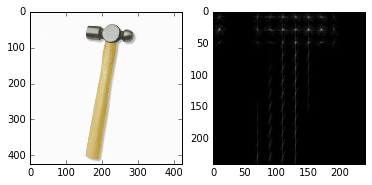

In [5]:
# an example of hog feature
example_img = io.imread('example.jpg')
hog_feature = pyhog.features_pedro(example_img /255., 30)

# visualize
hog_pic = pyhog.hog_picture(hog_feature)
plt.subplot(121)
plt.imshow(example_img)
plt.subplot(122)
plt.imshow(hog_pic,cmap=plt.cm.gray)

In [6]:
# preprocess (get subwindow, extract feature, add cosine window, fft...)

# position search preprocess
feature_map = get_subwindow(img_raw, pos, sz, feature='hog')

cos_window = np.outer(np.hanning(y.shape[0]), np.hanning(y.shape[1]))
x_hog = np.multiply(feature_map, cos_window[:, :, None])
xf = np.fft.fft2(x_hog, axes=(0,1))

# scale search preprocess
if nScales%2 == 0:
    scale_window = np.hanning(nScales+1)
    scale_window = scale_window[1:]
else:
    scale_window = np.hanning(nScales)
    
scaleSizeFactors = scaleFactors
min_scale_factor = np.power(scale_step,
                            np.ceil(np.log(5./np.min(sz))/np.log(scale_step)))

max_scale_factor = np.power(scale_step,
                            np.floor(np.log(np.min(np.divide(img_raw.shape[:2],
                                     base_target_size)))
                                     /np.log(scale_step)))


if scale_model_factor*scale_model_factor*np.prod(init_target_size)>scale_model_max_area:
    scale_model_factor = np.sqrt(scale_model_max_area/np.prod(init_target_size))

scale_model_sz = np.floor(init_target_size * scale_model_factor)

s = get_scale_subwindow(img_raw,pos,base_target_size,
                        currentScaleFactor * scaleSizeFactors,scale_window,
                        scale_model_sz)

sf = np.fft.fftn(s, axes=[0])

In [7]:
# training 

x_num = np.multiply(yf[:,:, None], np.conj(xf))
x_den = np.real(np.sum(np.multiply(xf, np.conj(xf)), axis=2))

s_num = np.multiply(ysf[:, None], np.conj(sf))
s_den = np.real(np.sum(np.multiply(sf, np.conj(sf)), axis=1))

In [8]:
# detecting

pos_list = []
pos_list.append(pos-base_target_size*currentScaleFactor/2.)
scale_list = []
scale_list.append(base_target_size)

print 'frame:',sequence._frame+1,'original position:',\
    pos-base_target_size*currentScaleFactor/2.
print 'frame:',sequence._frame+1,'original scale:',\
        base_target_size*currentScaleFactor

while sequence._frame < len(sequence._images)-1:

    # position search
    sequence._frame += 1
    test_img = io.imread(sequence.frame())
    test_patch = get_subwindow(test_img, pos, sz, scale_factor=currentScaleFactor)
    hog_feature_t = pyhog.features_pedro(test_patch/255., 1)
    hog_feature_t = np.lib.pad(hog_feature_t, ((1, 1),(1, 1),(0,0)), 'edge')
    xt = np.multiply(hog_feature_t, cos_window[:, :, None])
    xtf = np.fft.fft2(xt,axes=(0,1))
    response = np.real(np.fft.ifft2(np.divide(np.sum(np.multiply(x_num, xtf),
                                                 axis=2),(x_den+lamda))))
    v_centre, h_centre = np.unravel_index(response.argmax(), response.shape)
    vert_delta, horiz_delta = \
        [(v_centre - response.shape[0] / 2)*currentScaleFactor,
        (h_centre - response.shape[1] / 2)*currentScaleFactor]

    pos = [pos[0] + vert_delta, pos[1] + horiz_delta]
    print 'frame:',sequence._frame+1,'predicted position:',\
        pos-base_target_size*currentScaleFactor/2.
    pos_list.append(pos-base_target_size*currentScaleFactor/2.)

    # scale search
    st = get_scale_subwindow(test_img,pos,base_target_size,
                        currentScaleFactor * scaleSizeFactors,scale_window,
                        scale_model_sz)
    stf = np.fft.fftn(st, axes=[0])

    scale_reponse = np.real(np.fft.ifftn(np.sum(np.divide(np.multiply(s_num, stf),
          (s_den[:, None] + lamda_scale)), axis=1)))
    recovered_scale = np.argmax(scale_reponse)
    currentScaleFactor = currentScaleFactor * scaleFactors[recovered_scale]
    print 'frame:',sequence._frame+1,'predicted scale:',\
        base_target_size*currentScaleFactor
    scale_list.append(base_target_size*currentScaleFactor)

    if currentScaleFactor < min_scale_factor:
        currentScaleFactor = min_scale_factor
    elif currentScaleFactor > max_scale_factor:
        currentScaleFactor = max_scale_factor
        
sequence._frame = 0

frame: 1 original position: [ 132.  130.]
frame: 1 original scale: [ 115.   31.]
frame: 2 predicted position: [ 115.  124.]
frame: 2 predicted scale: [ 112.74509804   30.39215686]
frame: 3 predicted position: [ 107.30392157  120.38235294]
frame: 3 predicted scale: [ 112.74509804   30.39215686]
frame: 4 predicted position: [  88.67647059  117.44117647]


frame: 4 predicted scale: [ 110.53440984   29.79623222]


predit result (green box) and groundtruth (red box)


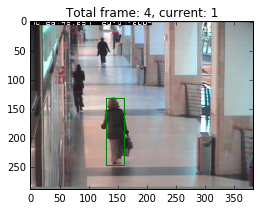

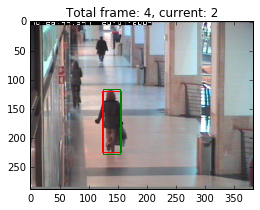

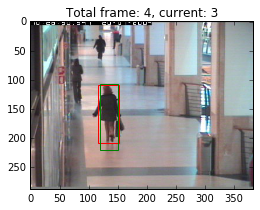

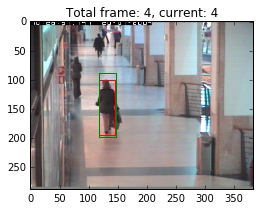

In [9]:
# visualize the result

print 'predit result (green box) and groundtruth (red box)'
while sequence._frame < len(sequence._images):
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    pd_rect = Rectangle(
            xy=(pos_list[sequence._frame][1], pos_list[sequence._frame][0]),
            width=scale_list[sequence._frame][1],
            height=scale_list[sequence._frame][0],
            facecolor='none',
            edgecolor='g',
    )
    plt.figure(figsize=(4,4))
    tracking_figure_axes = plt.subplot(111)
    tracking_figure_axes.add_patch(gt_rect)
    tracking_figure_axes.add_patch(pd_rect)
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence